# Exercise 5: Nonlinear optimization, camera calibration

In [535]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
from scipy.spatial.transform import Rotation
from scipy.optimize import least_squares

In [536]:
def box3d(n=16):
    points = []
    N = tuple(np.linspace(-1, 1, n))
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]:
        points.extend(set(it.permutations([(i, )*n, (j, )*n, N])))
    return np.hstack(points)/2

def Pi(points):
    if points.ndim == 2:
        n,p = points.shape
        new_points = np.vstack((points, np.ones(p)))
    elif points.ndim == 1:
        n = len(points)
        new_points = np.append(points, [1])
    return new_points

def PiInv(points):
    new_points = points[:-1]/points[-1]
    return new_points

def projectpoints(K,R,t,Q):
    homogeneous = Pi(Q)
    P = K @ ( np.hstack((R,t)) )
    q = P @ homogeneous
    q = PiInv(q)
    return q

def triangulate(qs, Ps):
    """
    qs : list of n pixel coordinates (q1, q2,. . . , qn)
    Ps : list of n projection matrices (P1, P2, . . . , Pn)
    return the triangulation of the point in 3D using the linear algorithm.
    """
    n = len(Ps)
    B = np.zeros((2*n,4))
    for i in range(n):
        B[i*2,:] = Ps[i][2,:] * qs[i][0] - Ps[i][0,:]
        B[i*2+1,:] = Ps[i][2,:] * qs[i][1] - Ps[i][1,:]
        
    Q = np.linalg.svd(B)[2][-1,:]
    Q.shape += (1,)
    return PiInv(Q)

In [537]:
np.ones(1).shape

(1,)

## Nonlinear optimization

In [538]:
R1 = np.identity(3)
R2 = R1
t1 = np.array([[0], 
              [0], 
              [1]])
t2 = np.array([[0], 
              [0], 
              [20]])
K1 = np.array([[700, 0, 600],
              [0, 700, 400],
              [0, 0, 1]])
K2 = K1
Q = np.array([[1], 
              [1], 
              [0]])

### Exercise 5.1

What are the projection matrices P1 and P2 ?

In [539]:
P1 = K1 @ ( np.hstack((R1,t1)) )
P2 = K2 @ ( np.hstack((R2,t2)) )

What is the projection of Q in cameras one and two (q1 and q2) ?

In [540]:
q1 = projectpoints(K1,R1,t1,Q)
q2 = projectpoints(K2,R2,t2,Q)
q1, q2

(array([[1300.],
        [1100.]]),
 array([[635.],
        [435.]]))

### Exercise 5.2

In [541]:
q1_ = q1 + np.array([[1], [-1]])
q2_ = q2 + np.array([[1], [-1]])

Qest = triangulate([q1_,q2_], [P1,P2])
q1est = projectpoints(K1,R1,t1,Qest)
q2est = projectpoints(K2,R2,t2,Qest)

print('err q1 : ', np.linalg.norm(q1est - q1))
print('err q2 : ', np.linalg.norm(q2est - q2))
print('err Q : ', np.linalg.norm(Qest - Q))

err q1 :  14.847231966697855
err q2 :  0.7426731182709606
err Q :  0.021221817353380967


In [542]:
Qest

array([[1.01527507e+00],
       [9.85270570e-01],
       [2.85786810e-04]])

### Exercise 5.3

In [548]:
def compute_residuals(Q, qs, Ps):
    n = len(Ps)
    res = np.zeros(2*n)
    
    Qcopy = np.copy(Q) # otherwise the dimension of Q is change outside the function while least_square still need it
    Qcopy.shape += (1,)
    Qh = Pi(Qcopy)
    
    for i in range(n):
        temp = PiInv(Ps[i] @ Qh) - qs[i]
        res[2*i:2*i+2] = temp[:,0]
    return res

    
def triangulate_nonlin(qs, Ps):
    """
    qs : list of n pixel coordinates (q1, q2,. . . , qn)
    Ps : list of n projection matrices (P1, P2, . . . , Pn)
    return the triangulation of the point in 3D using non linear optimization.
    """
    
    x0 = triangulate(qs, Ps).flatten()
    sol = least_squares(compute_residuals, x0, args=(qs, Ps))
    return sol

In [549]:
Qcopy = np.copy(Q.flatten()) # otherwise the dimension of Q is change outside the function while least_square still need it
Qcopy.shape += (1,)
Qh = Pi(Qcopy)

### Exercise 5.4

In [551]:
Qhat = triangulate_nonlin([q1_,q2_], [P1,P2])
Qhat

 active_mask: array([0., 0., 0.])
        cost: 0.9002473610883086
         fun: array([ 0.04731246, -0.04745426, -0.9462109 ,  0.94904651])
        grad: array([-2.16176345e-06, -2.17166621e-06,  2.17311579e-06])
         jac: array([[ 699.9700644 ,    0.        , -701.01733398],
       [   0.        ,  699.97007751, -698.92266846],
       [  34.99992315,    0.        ,   -1.75268555],
       [   0.        ,   34.99992752,   -1.74744797]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 4
        njev: 4
  optimality: 2.1731157866522466e-06
      status: 2
     success: True
           x: array([1.00153897e+00, 9.98546320e-01, 4.27473316e-05])

In [552]:
Qhat = Qhat['x'].reshape((3,1))
q1hat = projectpoints(K1,R1,t1,Qhat)
q2hat = projectpoints(K2,R2,t2,Qhat)

print('err q1 : ', np.linalg.norm(q1hat - q1))
print('err q2 : ', np.linalg.norm(q2hat - q2))
print('err Q : ', np.linalg.norm(Qhat - Q))

err q1 :  1.481223756268654
err q2 :  0.0740913310509589
err Q :  0.002117415199654577


## Camera calibration with OpenCV

### Exercise 5.6

A digital camera rotating images automatically is a problem because when you rotate an image
90◦ the camera matrix changes.

In [257]:
ims = []
for i in range(1,18):
    im = cv2.imread("data/" + str(i) + ".jpg")[:,:,::-1]
    ims.append(im)
    print(im.shape)

(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)


### Exercise 5.7

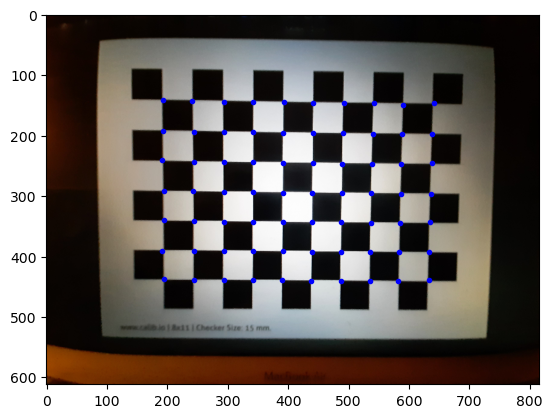

In [280]:
n = 7
m = 10

im_small = cv2.resize(ims[0], None, fx=0.25, fy=0.25)

q = np.zeros((2,n*m))
x = cv2.findChessboardCorners(im_small,(m,n))[1][:,0,0]
y = cv2.findChessboardCorners(im_small,(m,n))[1][:,0,1]
q[0,:] = x
q[1,:] = y

plt.imshow(im_small)
plt.plot(q[0,:],q[1,:],'b.')
plt.show()

In [259]:
cv2.findChessboardCorners(im_small,(10,7))[1].shape

(70, 1, 2)

In [260]:
corners = []
index = []
for i in range(17):
    res = cv2.findChessboardCorners(ims[i],(10,7))
    if res[0]:
        index.append(i)
        
        #q = np.zeros((2,n*m))
        #x = res[1][:,0,0]
        #y = res[1][:,0,1]
        #q[0,:] = x
        #q[1,:] = y
        corners.append(res[1])

In [261]:
index

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

### Exercise 5.8

In [389]:
def checkerboard_points(n, m):
    
    # allocate mem
    Q = np.zeros((3,m*n)) 
    
    li = np.arange(n) - (n-1)/2
    lj = np.arange(m) - (m-1)/2
    
    c = 0 
    for i in range(n):
        for j in range(m):
            Q[0,c] = li[i]
            Q[1,c] = lj[j]
            c += 1
    return Q

In [510]:
Q = checkerboard_points(n, m)
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objectPoints=[Q.T.astype('float32')]*17,
                                                                     imagePoints=corners, imageSize=(2448, 3264),
                                                                     cameraMatrix=None, distCoeffs=None, 
                                                                     flags = cv2.CALIB_FIX_K1+cv2.CALIB_FIX_K2+cv2.CALIB_FIX_K3
                                                                     +cv2.CALIB_FIX_K4+cv2.CALIB_FIX_K5+cv2.CALIB_FIX_K6
                                                                     +cv2.CALIB_ZERO_TANGENT_DIST)


In [511]:
cameraMatrix.shape, len(rvecs), len(tvecs)

((3, 3), 17, 17)

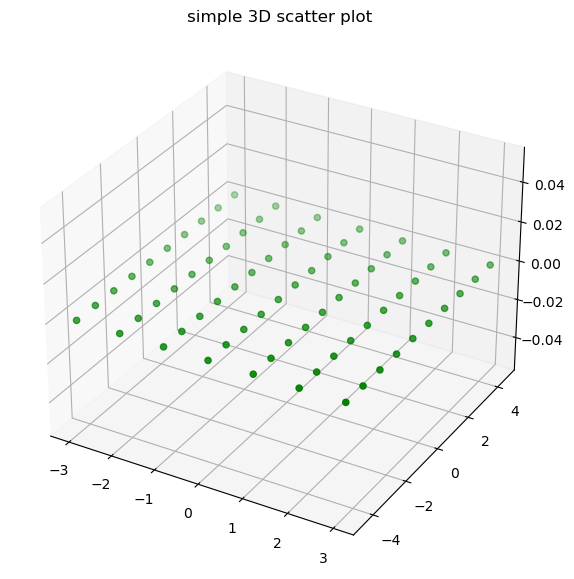

In [512]:
from mpl_toolkits import mplot3d
 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(Q[0,:], Q[1,:], Q[2,:], color = "green")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

### Exercise 5.9

In [513]:
# convert rotation to the right format
qs_hat = []
qs = []
Rs = []
RMSEs = []
for i in range(17):
    # compute reprojection
    Ri = cv2.Rodrigues(rvecs[i])[0] # transform rotation matrix to the right format
    Rs.append(Ri)
    qi_hat = projectpoints(cameraMatrix,Ri,tvecs[i],Q) # reproj
    qs_hat.append(qi_hat) # save
    
    # get corners detected on images by open cv in the right format
    qi = np.zeros((2,n*m))
    qi[0,:] = corners[i][:,0,0]
    qi[1,:] = corners[i][:,0,1]
    qs.append(qi)
    
    # compute reprojection error for each image
    RMSE = (qi - qi_hat)**2
    RMSE = np.sum(np.sqrt(RMSE[0] + RMSE[1]))
    RMSEs.append(RMSE)


In [514]:
RMSEs

[83.24806821978525,
 98.58485258479509,
 93.95350260956495,
 94.54085531893104,
 94.6253376810685,
 94.26228799886131,
 63.397101439210495,
 100.24102417472204,
 95.94195775539974,
 76.23062924444798,
 69.20881616636177,
 75.71856655424814,
 69.57027992174805,
 80.88934844512403,
 79.30470165772563,
 83.24325000520783,
 70.94307220111206]

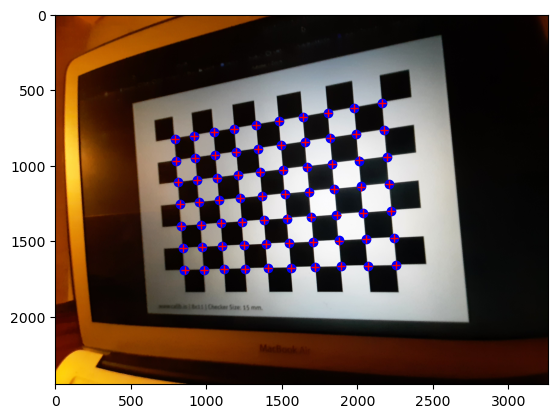

RMSE :  63.397101439210495


In [515]:
# plot results for image with the lowest RMSE

imin = np.argmin(RMSEs)

plt.imshow(ims[imin])
plt.plot(qs[imin][0,:],qs[imin][1,:],'bo')
plt.plot(qs_hat[imin][0,:],qs_hat[imin][1,:],'r+')
plt.show()

print('RMSE : ', RMSEs[imin])

### Exercise 5.10

In [516]:
Qcube = 2*box3d() +1

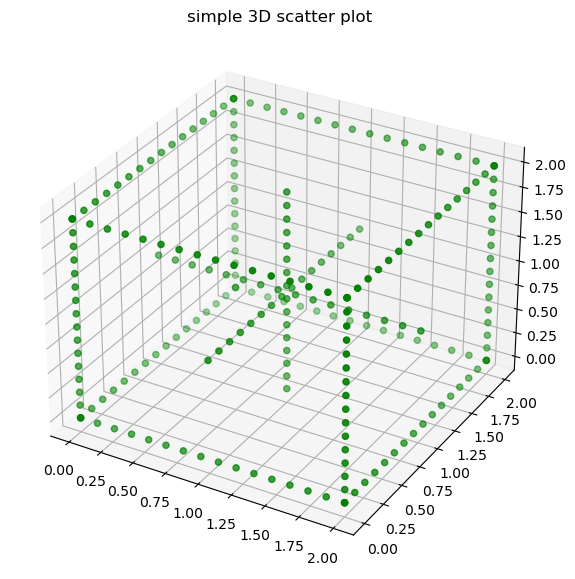

In [517]:
from mpl_toolkits import mplot3d
 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(Qcube[0,:], Qcube[1,:], Qcube[2,:], color = "green")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

In [518]:
i = imin
qcube_hat = projectpoints(cameraMatrix,Rs[i],tvecs[i],Qcube) # reproj

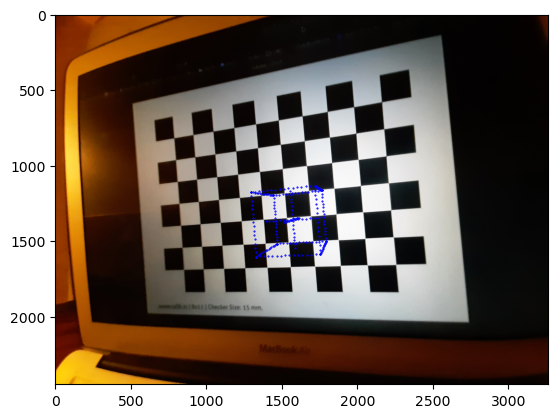

In [519]:
plt.imshow(ims[i])
plt.plot(qcube_hat[0,:],qcube_hat[1,:],'b.', markersize=1)
plt.show()

### Exercise 5.11

Higher RMSE